# Imports

In [ ]:
%pip install fiftyone --user
import fiftyone
# You don't have to run this cell, if you already have dataset on machine

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU enable')
    except Exception as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU enable


# Data

Load and prepare your dataset. It should consist of at least 50k images from any openimages split.

In [4]:
dataset = fiftyone.zoo.load_zoo_dataset('open-images-v7', split='train', label_types=['classifications'], max_samples=70000)
# You don't have to run this cell, if you already have dataset on machine
# If you don't have dataset, run this cell and then move directory with images near to this file
# On Windows it will be like this "C:\Users\user\fiftyone\open-images-v7\train\data"
# You have to move the "data" directory to this notebook 

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v7-train-70000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [4]:
root_path = 'data'
images = os.listdir(f'{root_path}/')

In [5]:
filepaths = []

for filename in images:
    file = f'{root_path}/{filename}'
    filepaths.append(file)

In [6]:
pd_data = pd.DataFrame(
        filepaths,
        columns=['filepaths']
        )

In [7]:
pd_data.head(10)

,filepaths
0,data/000002b66c9c498e.jpg
1,data/000002b97e5471a0.jpg
2,data/000002c707c9895e.jpg
3,data/0000048549557964.jpg
4,data/000004f4400f6ec5.jpg
5,data/0000071d71a0a6f6.jpg
6,data/000013ba71c12506.jpg
7,data/000018acd19b4ad3.jpg
8,data/00001bc2c4027449.jpg
9,data/00001bcc92282a38.jpg


# Image augmentation and crops

Implement image augmentation and crops as described in DINO.

In [56]:
paths_dataset = tf.data.Dataset.from_tensor_slices(pd_data.filepaths)

In [54]:
def geometric_augmentation(image, size, crop_scale):
    ratio = np.random.uniform(0.4, 1)
    scale = np.random.uniform(crop_scale[0], crop_scale[1])

    crop_size = size * scale
    crop_size = int(np.sqrt(crop_size ** 2 * ratio)), int(np.sqrt(crop_size ** 2 / ratio))
    
    image = tf.image.random_crop(image, size=(crop_size[0], crop_size[1], 3))
    image = tf.image.resize(image, size=(size, size))
    image = tf.image.flip_left_right(image)
    return image

In [55]:
def color_transform(image):
    p1 = np.random.random()
    p2 = np.random.random()
    if p1 >= 0.2:
        image = tf.image.adjust_brightness(image, 0.4)
        image = tf.image.adjust_contrast(image, 0.4)
        image = tf.image.adjust_saturation(image, 0.2)
        image = tf.image.adjust_hue(image, 0.1)

    if p2 >= 0.8:
        image = tf.image.rgb_to_grayscale(image)
    
    return image

In [57]:
def gaussian_filter(image, probability): # global_transfo1_extra
    p = np.random.random()
    
    if p >= probability:
        sigma = np.random.uniform(0.1, 2)
        image = tf.convert_to_tensor(cv2.GaussianBlur(image.numpy(), (9,9), sigmaX=sigma, borderType=cv2.BORDER_DEFAULT))
    
    return image

In [58]:
def random_solarize(image, threshold=128, p=0.2):
    if np.random.random() > p:
        return image
    
    mask = image > threshold
    masked_image = tf.where(mask, 255 - image, image)

    return masked_image

In [59]:
def normalize(image):
    return tf.image.per_image_standardization(image)

In [60]:
def dino_augmentation(image, global_crops_scale=(0.14, 1), local_crops_scale=(0.05, 0.4), local_crops_number=3, global_crops_size=224, local_crops_size=96):
    output = {}

    # global crops
    im1_base = geometric_augmentation(image, global_crops_size, global_crops_scale)
    global_crop_1 = normalize(gaussian_filter(color_transform(im1_base), 0))

    im2_base = geometric_augmentation(image, global_crops_size, global_crops_scale)
    global_crop_2 = normalize(random_solarize(gaussian_filter(color_transform(im2_base), 0.9)))

    output['global_crops'] = [global_crop_1, global_crop_2]

    output['global_crops_teacher'] = [global_crop_1, global_crop_2]

    local_crops = [
            gaussian_filter(geometric_augmentation(image, local_crops_size, local_crops_scale), 0.5) for _ in range(local_crops_number)
        ]
    
    output["local_crops"] = local_crops
    output["offsets"] = ()

    return output

In [8]:
image1 = tf.io.decode_image(tf.io.read_file('data/000002b66c9c498e.jpg'))

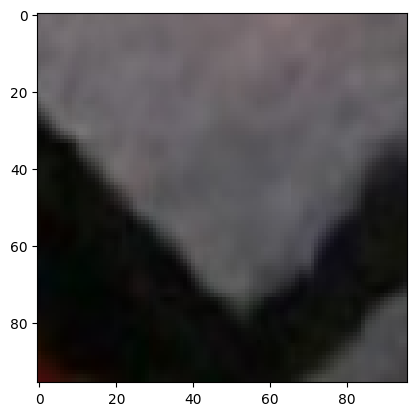

In [103]:
image = geometric_augmentation(image1, 96, (0.4, 0.8))
image = tf.cast(image, tf.uint8)
plt.imshow(image.numpy())

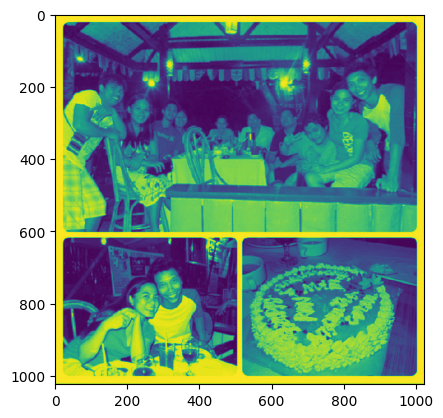

In [85]:
image = color_transform(image1)
plt.imshow(image.numpy())

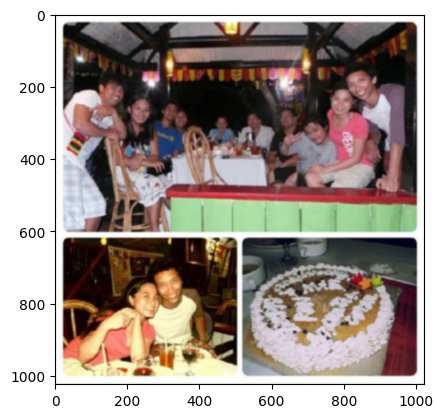

In [89]:
image = gaussian_filter(image1, 0.2)
plt.imshow(image.numpy())

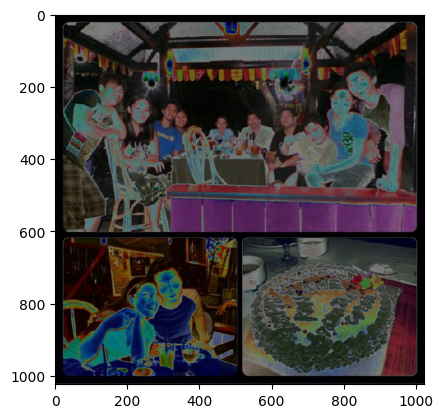

In [91]:
image = random_solarize(image1)
plt.imshow(image.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


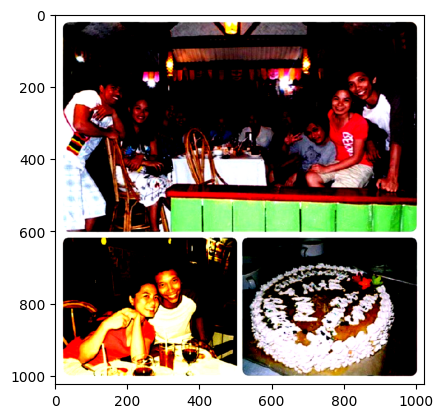

In [80]:
image = normalize(image1)
plt.imshow(image.numpy())

In [ ]:
image_dataset = paths_dataset.map(lambda x: dino_augmentation(tf.io.decode_image(tf.io.read_file(x)), expand_animations=False, channels=3))

In [ ]:
batch_image_dataset = image_dataset.batch(64) # мб не 64...

# Losses

Implement the losses and loss additions. DINO, koleo, sinkhorn_knopp, softmax_centering.

# Backbone

Implement transofmer model as described in DINO, including the DINO head. Don't forget the teacher weights update.

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

Split your data (extracted features and labels) into train and test subsets.

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [ ]:
train_X = tf.data.Dataset.from_tensor_slices(X_train)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(128)

test_X = tf.data.Dataset.from_tensor_slices(X_test)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(128)

# Training

Train the model as described in DINO.

# Evaluation

Show that features extracted by your model are similar for similar images and different for others.

# Bonus

Train a simple classification model on top of your extracted features on some simple dataset.